In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy import io
from sigtools.sigtools import *
from scipy.signal import stft, istft, spectrogram, chirp, butter, lfilter, freqz
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from numpy import linalg


Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [92]:
figPath = './figs-01-31/'
fs = 32.768e6
f1 = 1e6
nfft = 19
nperseg = 19
beta_loss = 'kullback-leibler'
save_fig = False
exp_name = '1sin_noise'

In [6]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [7]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

In [8]:
def mean_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.mean(y[i:i+window_length:hop_size]))
    return np.asarray(window)

In [9]:
def median_window(y, window_length, hop_size=1):
    aux = (y.shape[0] - window_length)//hop_size
    if aux is not int(aux):
         raise ValueError('Window size and hop size are incompatible')
            
    number_of_windows = aux + 1
    window = []
    for i in range(number_of_windows):
        window.append(np.median(y[i:i+window_length:hop_size]))
    return np.asarray(window)

# Generate and mix signals

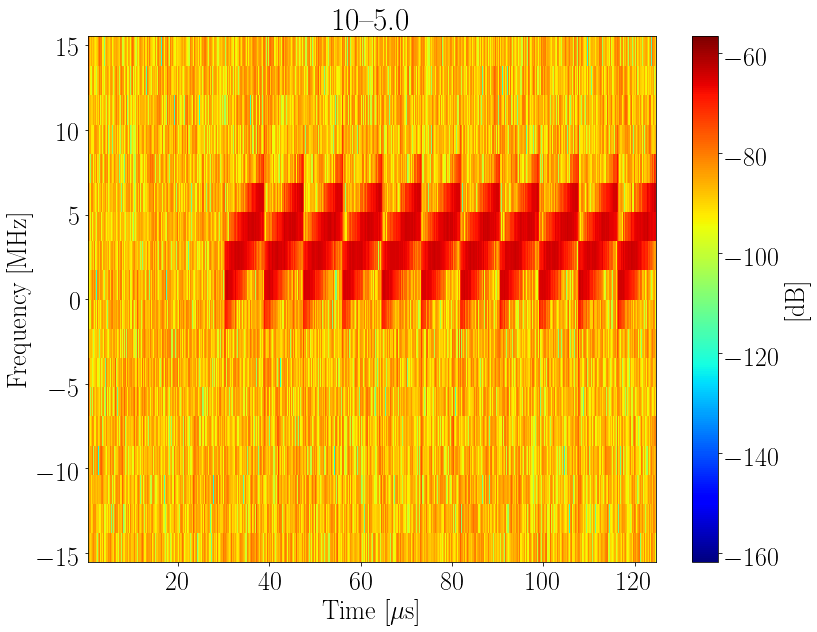

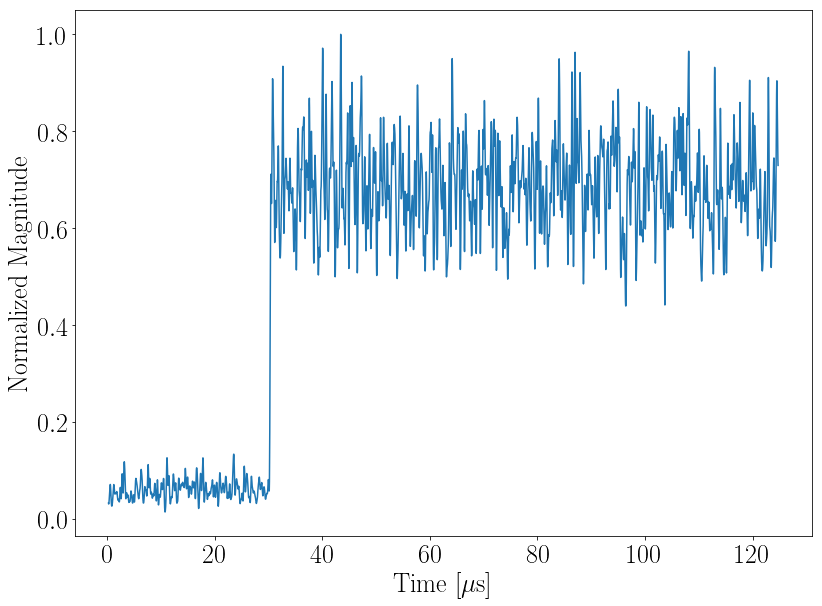

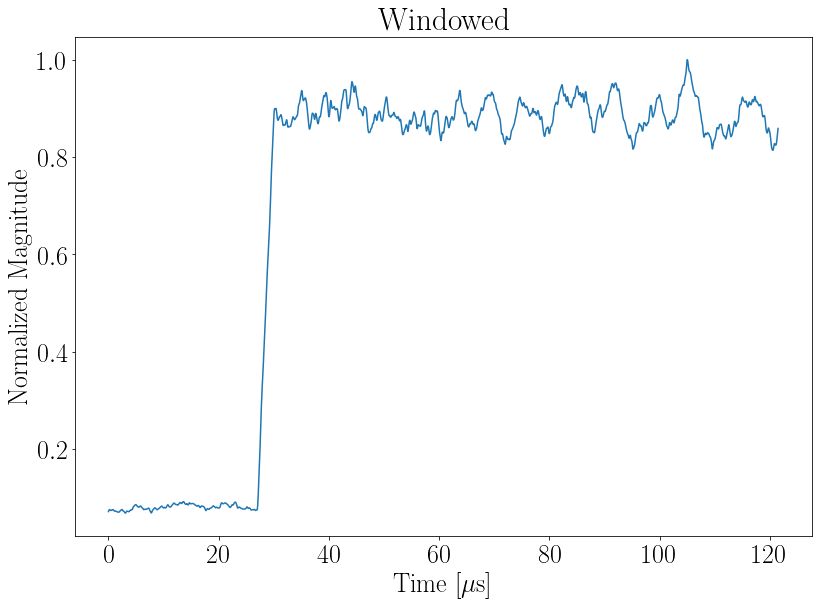

In [94]:
f0 = 0
stepFreq = 1
secondsOfData = 8.62e-6
numberOfSamples = int(secondsOfData*fs)
totalSamples = 4096

bandwidth = np.arange(1, 20+stepFreq, stepFreq)*1e6

bandwidth = np.array([5e6])

# bandwidth = np.array([1])*1e6

# JNRVector = [-16, -15, -14, -13, -12, -11]
# JNRVector = [float("inf")]
JNRVector = [10]


JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

for k in list(bandwidth):
    
    t = np.arange(0, secondsOfData - 1/fs, 1/fs)    
    f = ((bandwidth/2)/secondsOfData)*t + f0

    signal1 = np.exp(1j*2*np.pi*f*t)    
    signal1 = np.tile(signal1, np.floor(100e-6*fs).astype(int)//numberOfSamples)
    pow1 = pow_eval(signal1)
    signal1 = np.concatenate((np.zeros(totalSamples - signal1.shape[0]), signal1))

    noise = np.random.randn(len(signal1)) + 1j*np.random.randn(len(signal1))
    powNoise = pow_eval(noise)

    window_length = int(3e-6*fs)

    for j, i in enumerate(JNR):
        powAux = pow1/i
        noise2 = noise*np.sqrt(powAux/powNoise)
        data = signal1+noise2
        
        cmap = plt.get_cmap('jet')
        Pxx, freqs, bins, _ = plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=nfft-1, cmap=cmap,
                                          detrend='none', sides='twosided')
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inputNMF = np.abs(Pxx)
        inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)
        specdB = 10*np.log10(inputNMF)
        v = ax.pcolormesh(bins*1e6, freqs/1e6, specdB, cmap=cmap, vmin=vmin, vmax=vmax)

        if j == 1:
            vmin = np.min(specdB)
            vmax = np.max(specdB)

        ax.set_ylabel('Frequency [MHz]')
        ax.set_xlabel('Time [$\mu$s]')
        fig.colorbar(v).ax.set_ylabel('[dB]')
        plt.tight_layout()
        saveFig(fig, figPath, ''.join(['spec_input_', exp_name]), save_fig=save_fig)
        plt.title(''.join([str(JNRVector[j]), '--', str(k//1e6)]))
        plt.show()

        model = NMF(init='nndsvda', max_iter=10000, verbose=0, random_state=1, tol=1e-16, 
                      beta_loss=beta_loss, n_components=1, solver='mu')
        W = model.fit_transform(inputNMF)
        H = model.components_

        for l in range(H.shape[0]):
            HNorm = H[l,:]/np.max(H[l,:])
            H2 = mean_window(HNorm, window_length)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(bins*1e6, HNorm)
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(l)]), save_fig=save_fig)
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            taux = np.linspace(0, H2.shape[0]/fs, H2.shape[0])*1e6
            ax.plot(taux, H2/np.max(H2))
            ax.set_title('Windowed')
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(l)]), save_fig=save_fig)
            plt.show()
            

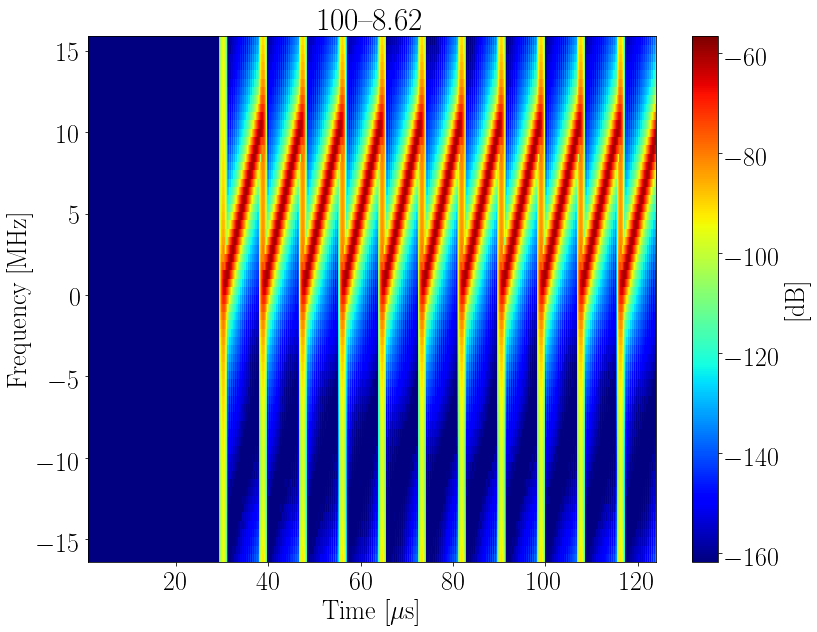

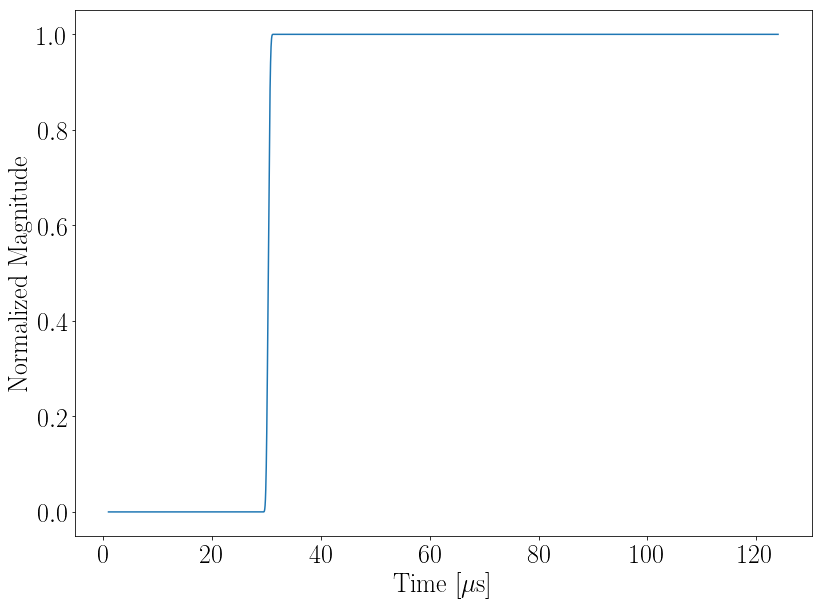

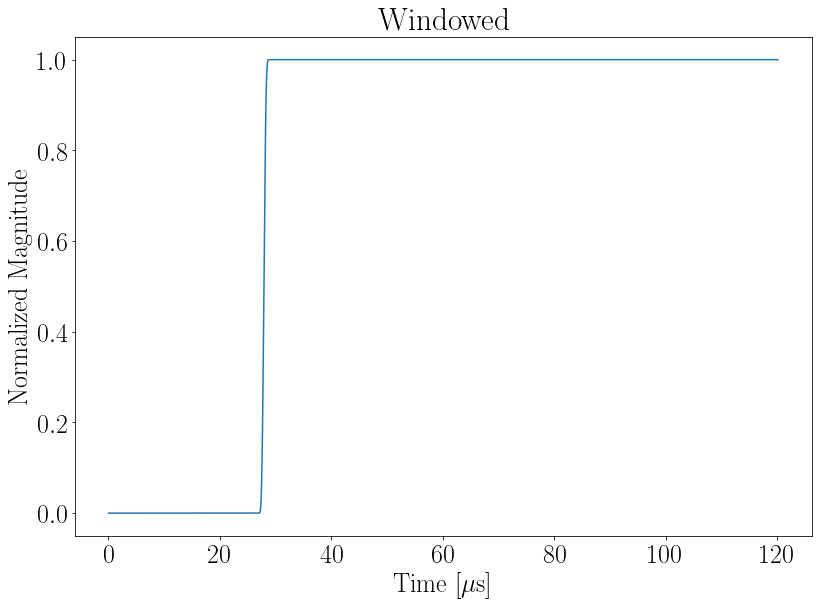

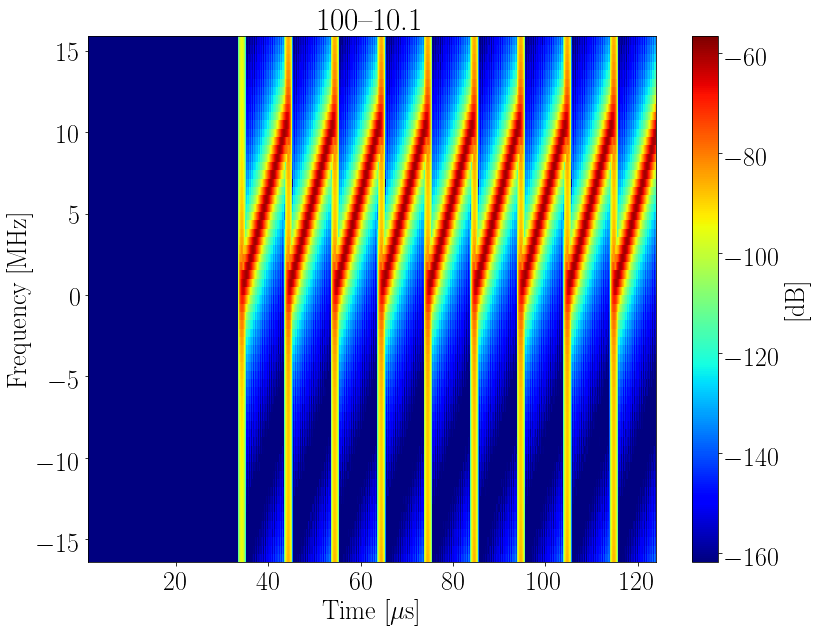

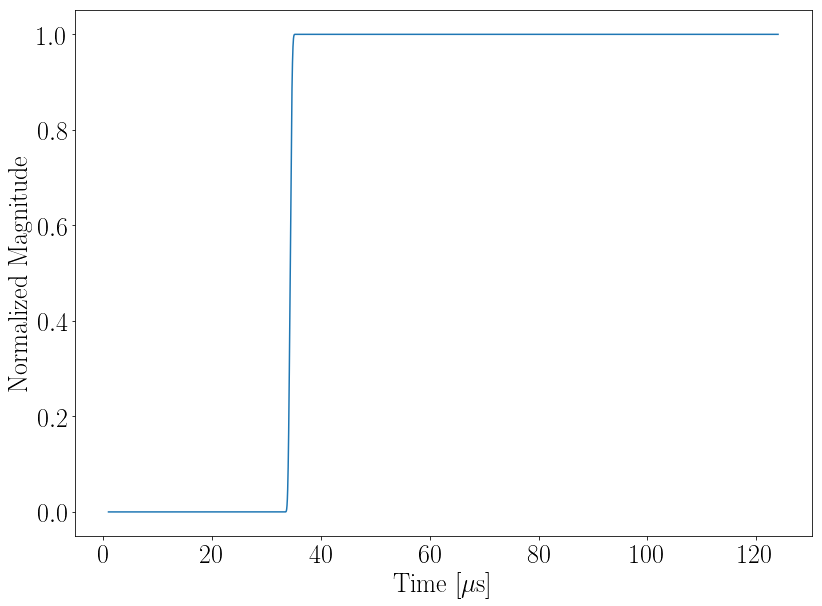

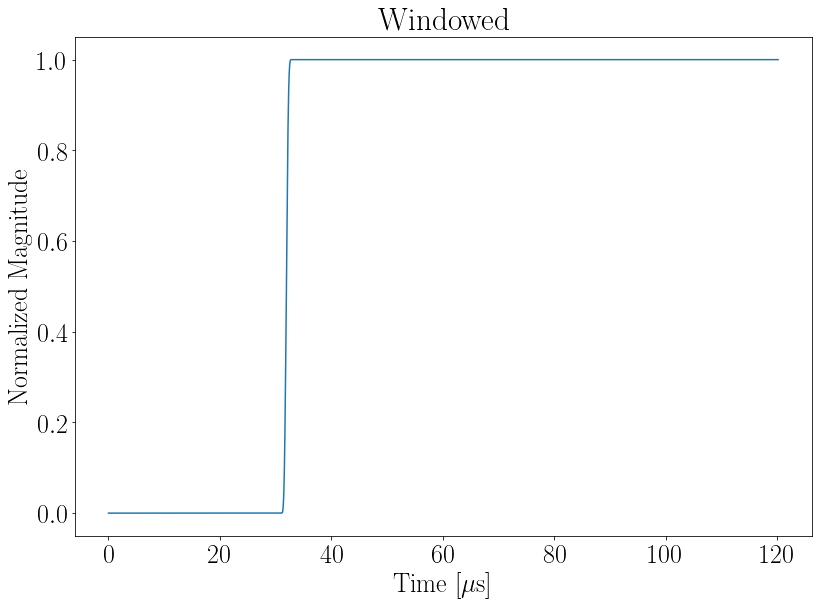

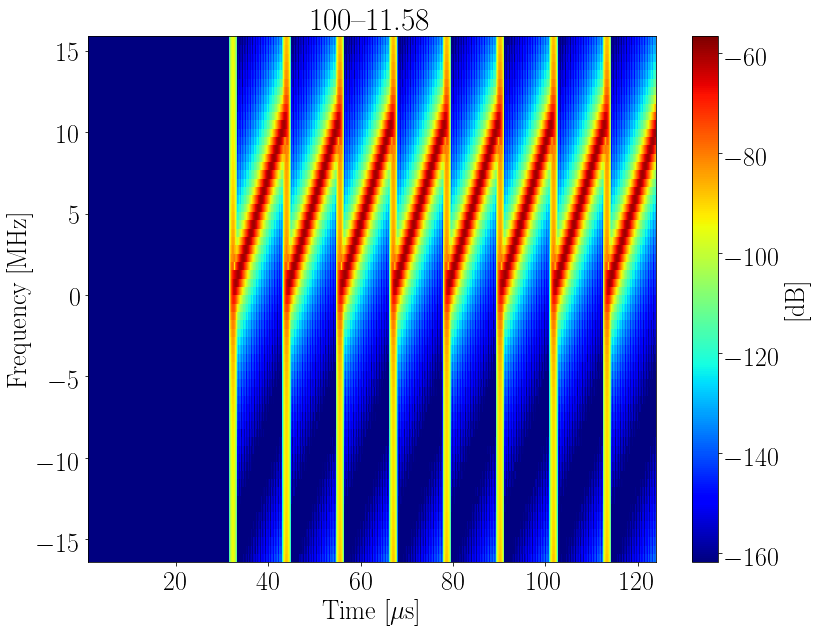

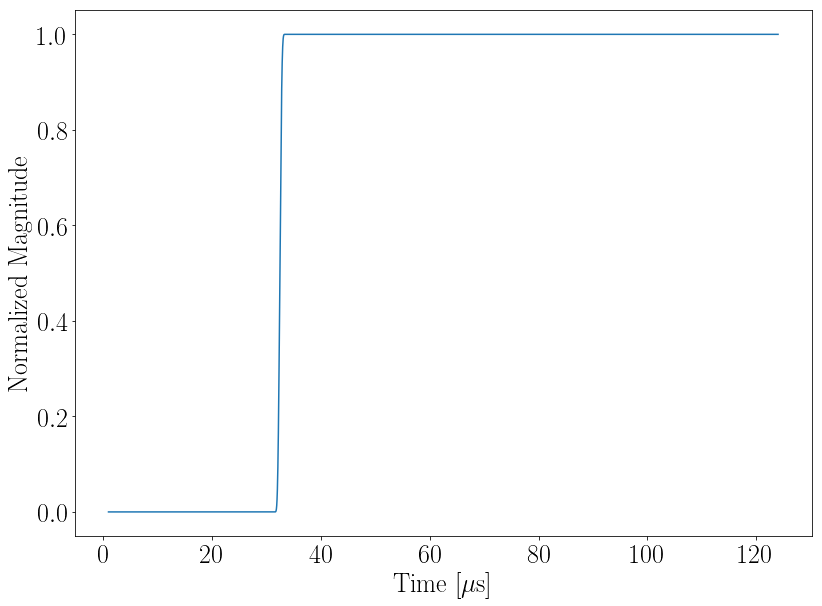

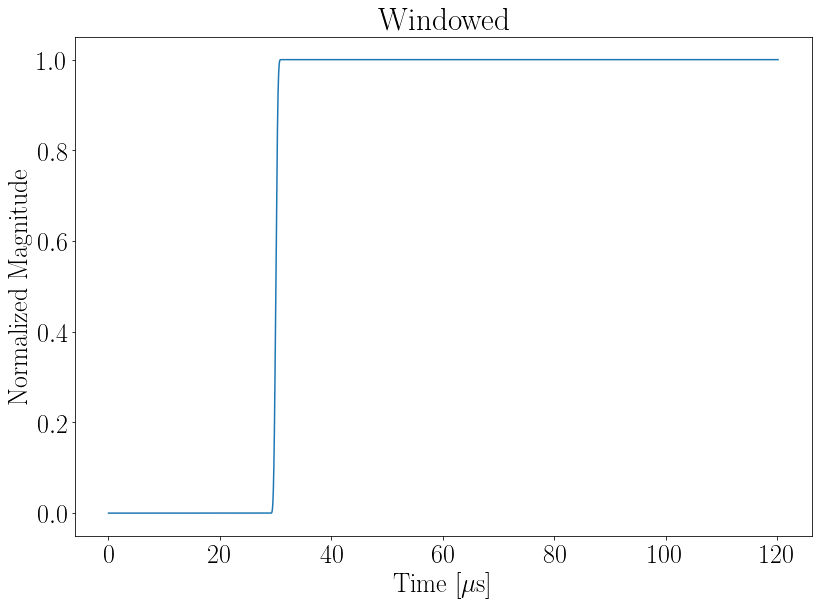

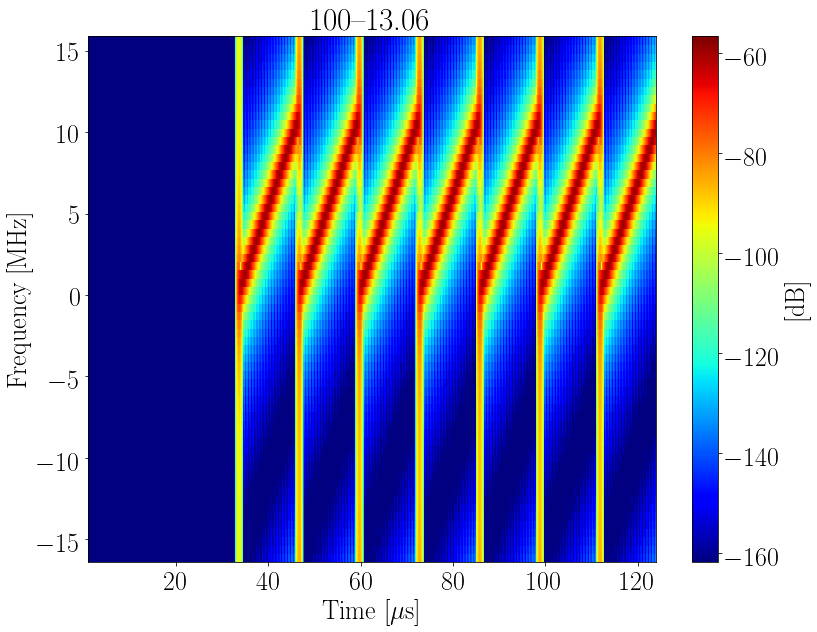

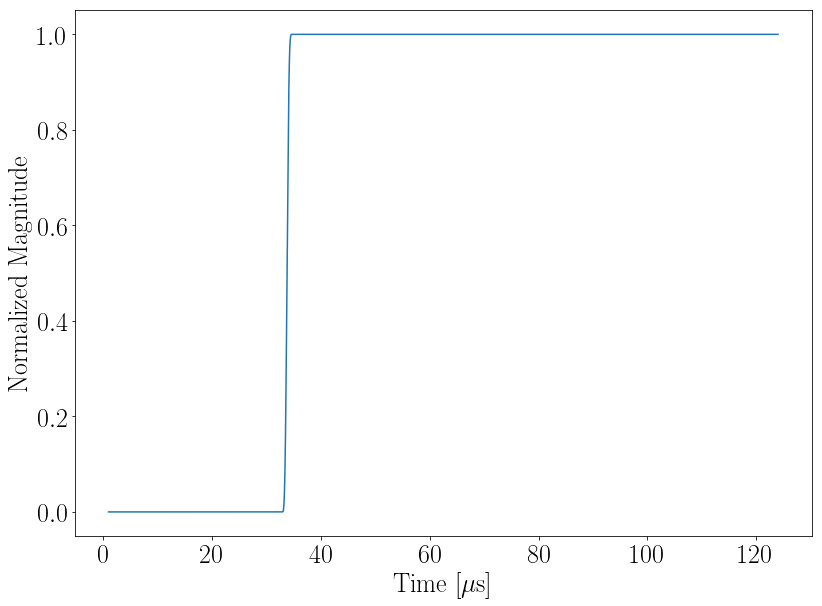

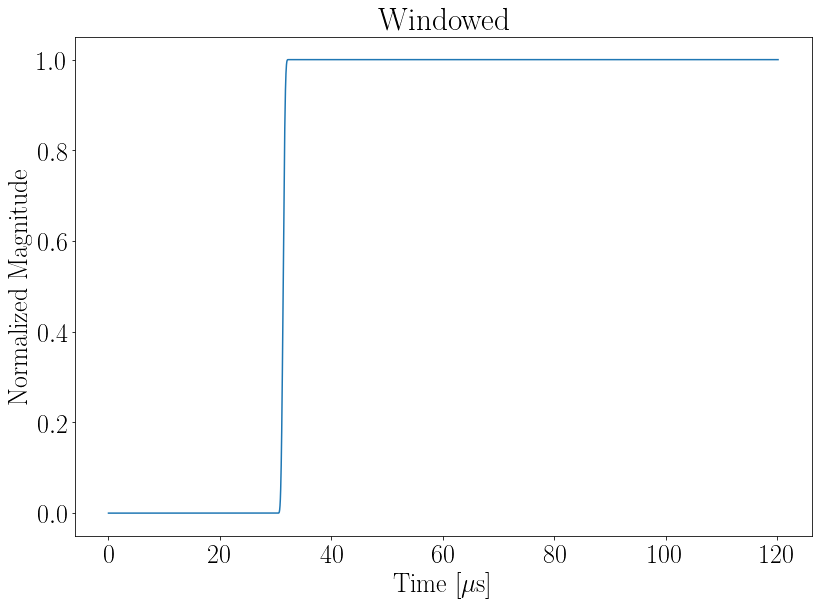

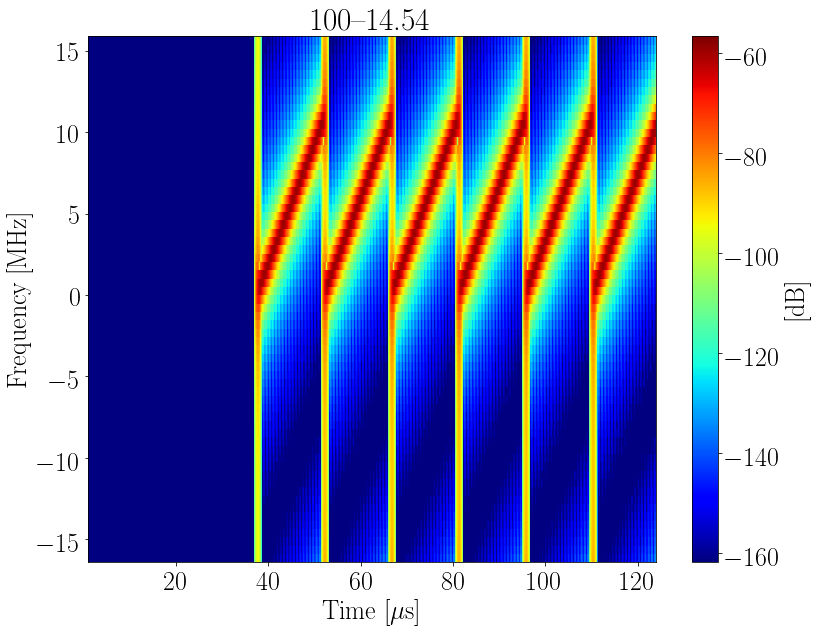

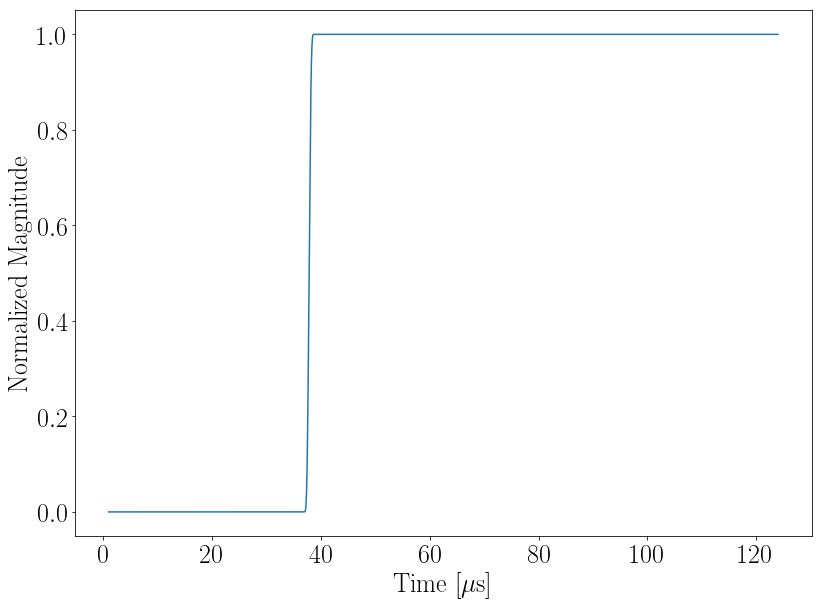

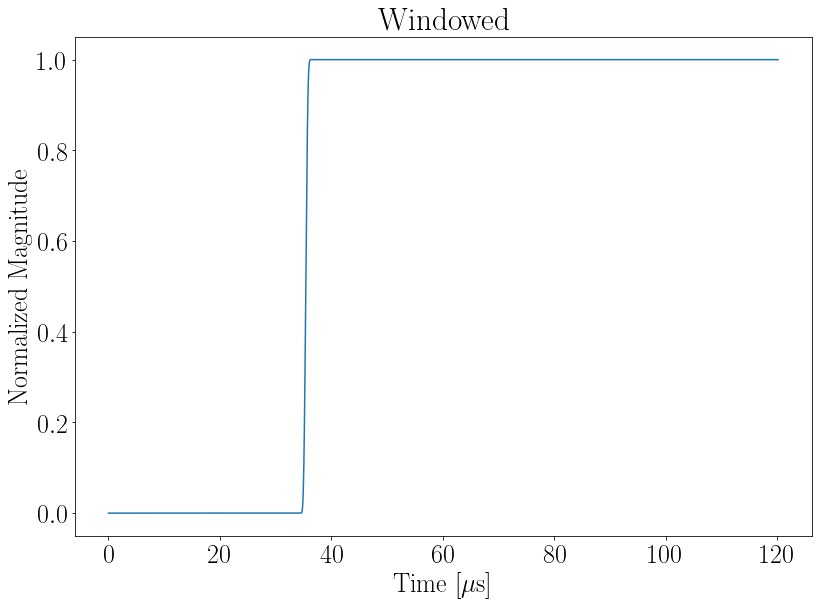

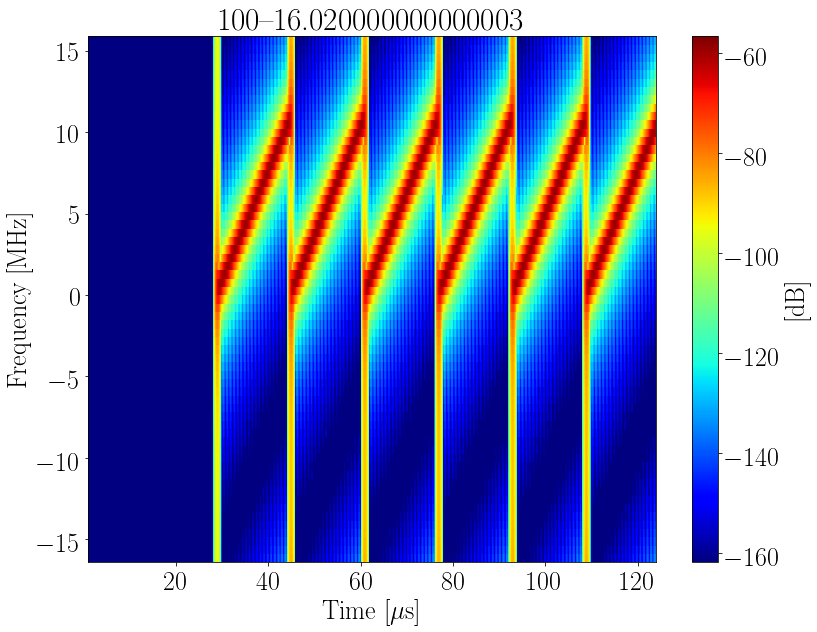

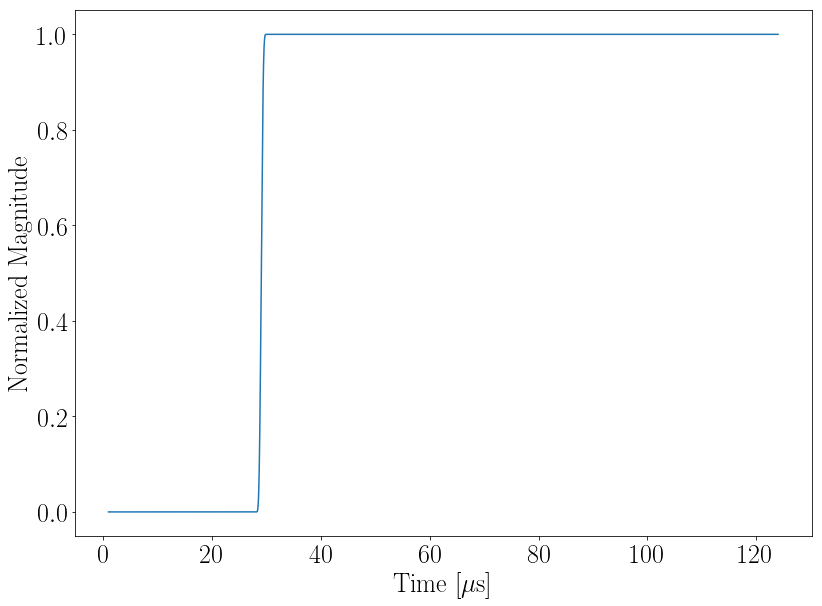

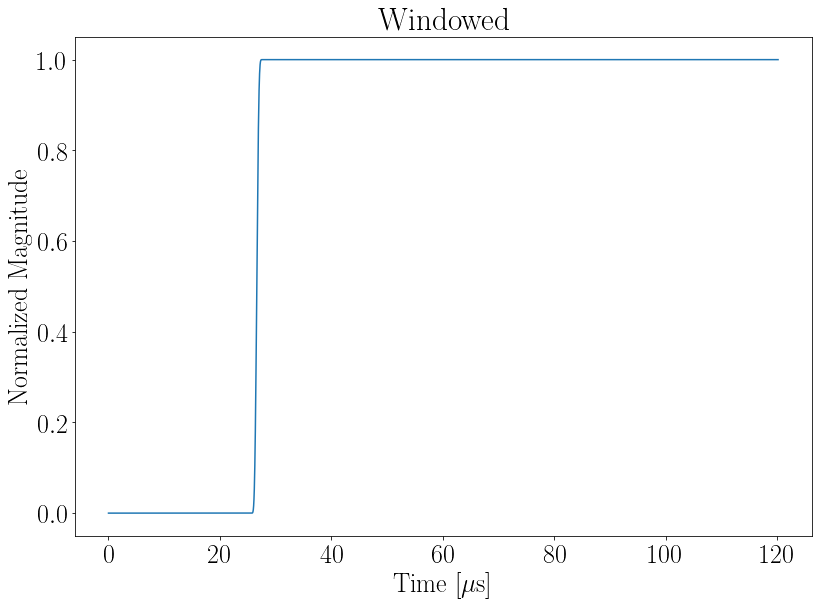

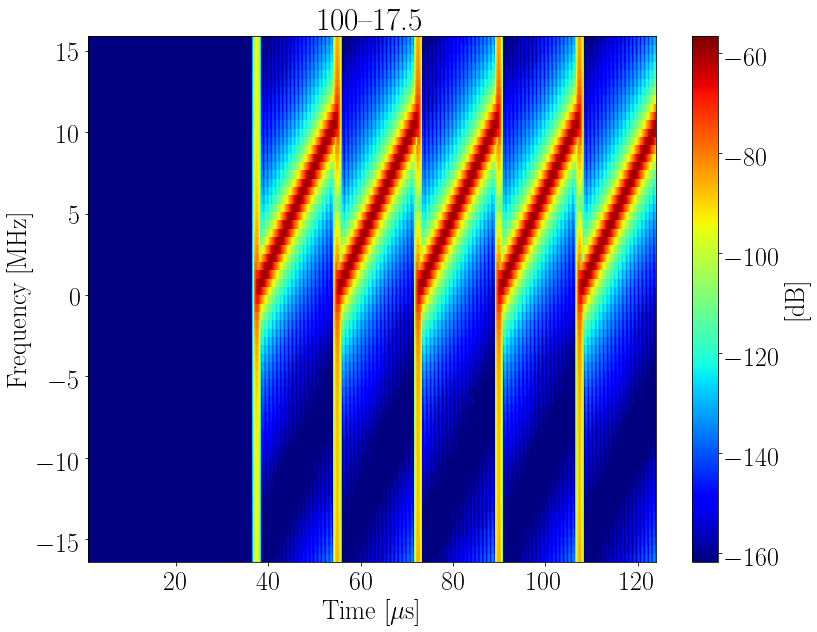

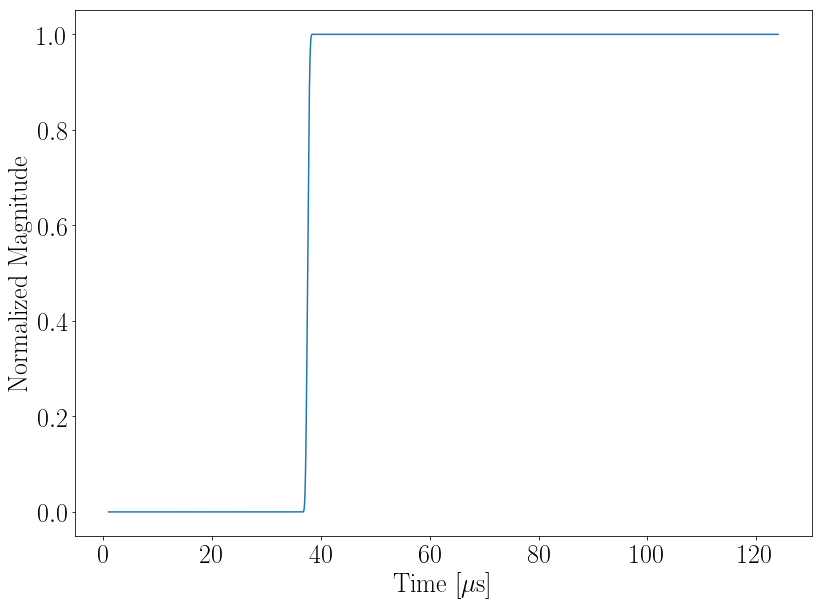

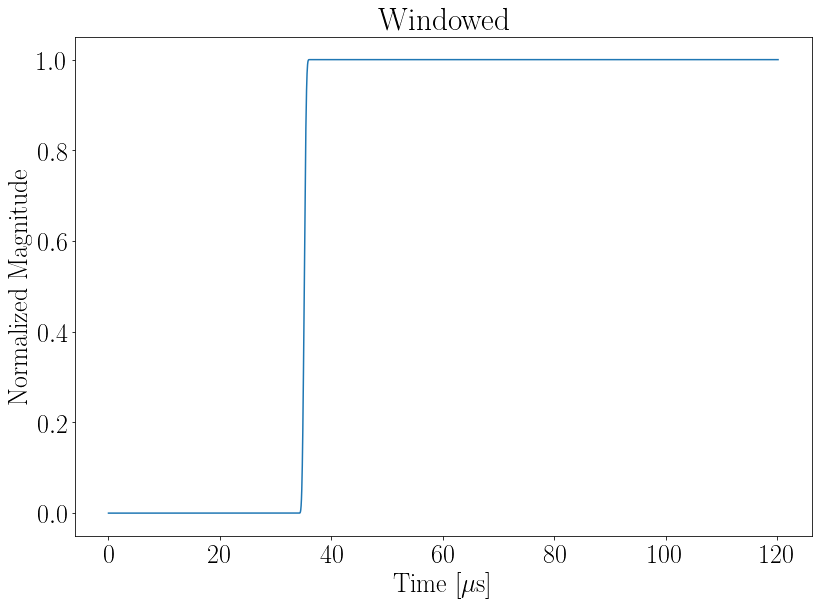

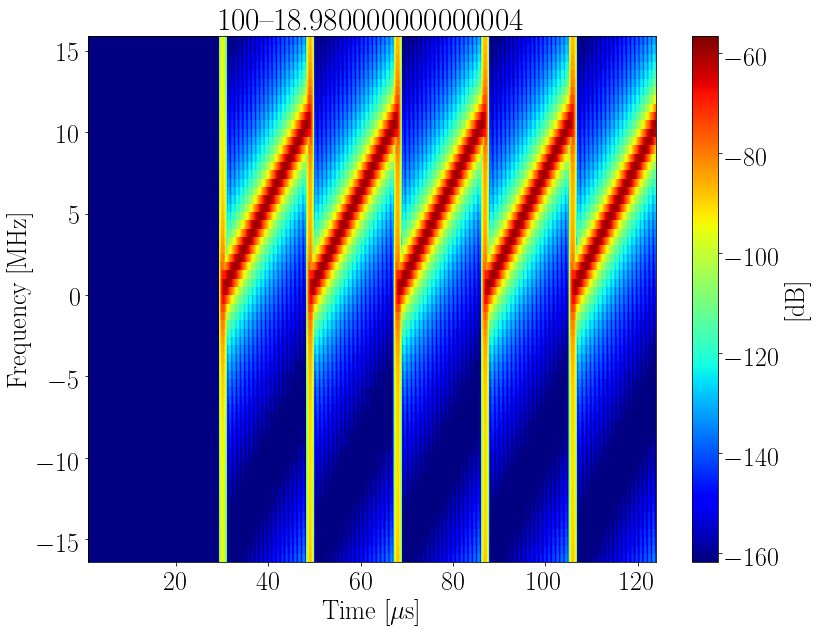

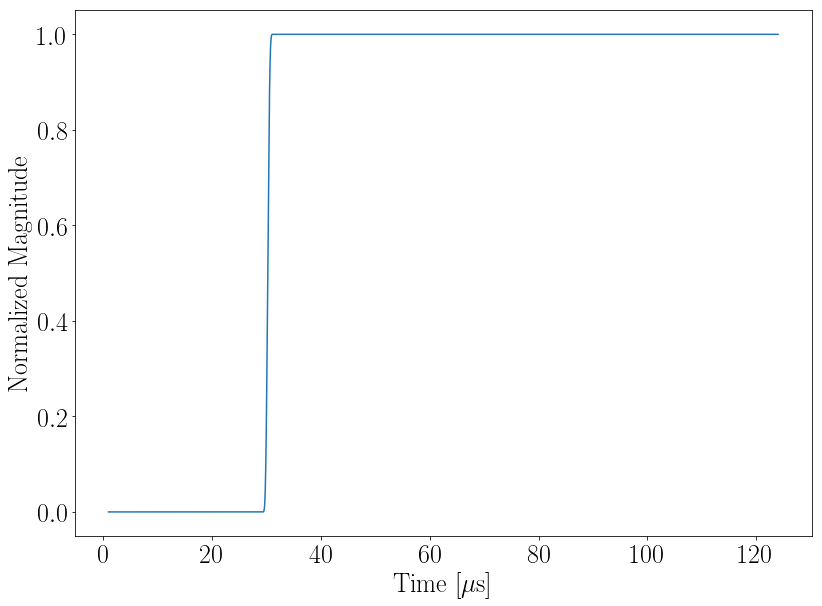

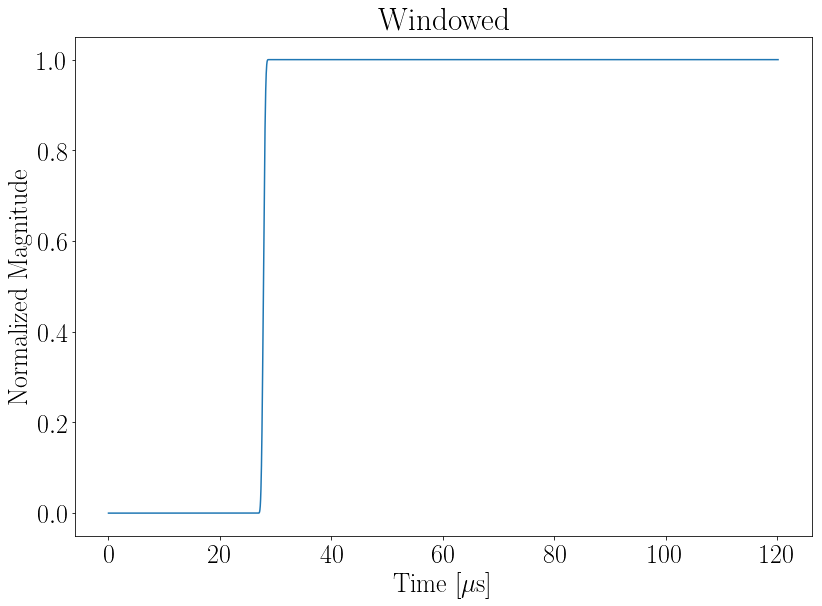

In [77]:
f0 = 0
stepPeriod = 1.48
totalSamples = 4096

secondsOfData = np.arange(8.62, 18.97+stepPeriod, stepPeriod)*1e-6
bandwidth = 10.72e6
JNRVector = [100]


JNR = []
[JNR.append(db2pow(i)) for i in JNRVector]

for k in list(secondsOfData):
    
    numberOfSamples = int(k*fs)

    t = np.arange(0, k - 1/fs, 1/fs)

#     f = f0 + (k/secondsOfData)*t - bandwidth/2
    
    f = ((bandwidth/2)/k)*t + f0

    signal1 = np.exp(1j*2*np.pi*f*t)    
    signal1 = np.tile(signal1, np.floor(100e-6*fs).astype(int)//numberOfSamples)
    pow1 = pow_eval(signal1)
    signal1 = np.concatenate((np.zeros(totalSamples - signal1.shape[0]), signal1))

    noise = np.random.randn(len(signal1)) + 1j*np.random.randn(len(signal1))
    powNoise = pow_eval(noise)

    window_length = int(3e-6*fs)

    for j, i in enumerate(JNR):
        powAux = pow1/i
        noise2 = noise*np.sqrt(powAux/powNoise)
        data = signal1+noise2
        
        cmap = plt.get_cmap('jet')
        Pxx, freqs, bins, _ = plt.specgram(data, Fs=fs, NFFT=nfft, noverlap=nfft-1, cmap=cmap,
                                          detrend='none', sides='twosided')
        plt.close()
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inputNMF = np.abs(Pxx)
        inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)
        specdB = 10*np.log10(inputNMF)
        v = ax.pcolormesh(bins*1e6, freqs/1e6, specdB, cmap=cmap, vmin=vmin, vmax=vmax)

        if j == 1:
            vmin = np.min(specdB)
            vmax = np.max(specdB)

        ax.set_ylabel('Frequency [MHz]')
        ax.set_xlabel('Time [$\mu$s]')
        fig.colorbar(v).ax.set_ylabel('[dB]')
        plt.tight_layout()
        saveFig(fig, figPath, ''.join(['spec_input_', exp_name]), save_fig=save_fig)
        plt.title(''.join([str(JNRVector[j]), '--', str(k*1e6)]))
        plt.show()

        model = NMF(init='nndsvda', max_iter=10000, verbose=0, random_state=1, tol=1e-16, 
                      beta_loss=beta_loss, n_components=1, solver='mu')
        W = model.fit_transform(inputNMF)
        H = model.components_

        for l in range(H.shape[0]):
            HNorm = H[l,:]/np.max(H[l,:])
            H2 = median_window(HNorm, window_length)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.plot(bins*1e6, HNorm)
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(l)]), save_fig=save_fig)
            plt.show()

            fig = plt.figure()
            ax = fig.add_subplot(111)
            taux = np.linspace(0, H2.shape[0]/fs, H2.shape[0])*1e6
            ax.plot(taux, H2/np.max(H2))
            ax.set_title('Windowed')
            ax.set_xlabel('Time [$\mu$s]')
            ax.set_ylabel('Normalized Magnitude')
            fig.tight_layout()
            saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(l)]), save_fig=save_fig)
            plt.show()
            

In [54]:
t[1]-t[0]

3.0676156583629894e-08

# Saving log file

In [ ]:
import json

In [ ]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)